# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J.*

**Names:**

* *Kenza Driss*
* *Maximilien Hoffbeck*
* *Jaeyi Jeong*
* *Yoojin Kim*
---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

In [8]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from epidemics_helper import SimulationSIR

In [9]:
# Load NYC road network graph
with open('../data/nyc_augmented_network.json', 'r') as f:
    data = json.load(f)

# Create the graph
G = nx.Graph()
for node in data["nodes"]:
    G.add_node(node["id"], coordinates=node["coordinates"])

for link in data["links"]:
    G.add_edge(link["source"], link["target"])

# Re-index nodes to be consecutive integers [0, N-1]
mapping = {old_id: new_id for new_id, old_id in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)

In [10]:
# Epidemic parameters
beta = 10.0
gamma = 0.1
source_node = mapping[23654]
n_days = 100

# Initialize and run the Epidemic simulation
sim = SimulationSIR(G, beta=beta, gamma=gamma, verbose=False)
sim.launch_epidemic(source=source_node, max_time=n_days)


/var/folders/b5/pzl_pqqs6sz2qp_2yrpngsv00000gp/T/ipykernel_36111/3238278707.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s = np.sum(sim.get_node_status(i, t) == 0 for i in range(sim.n_nodes)) / sim.n_nodes
/var/folders/b5/pzl_pqqs6sz2qp_2yrpngsv00000gp/T/ipykernel_36111/3238278707.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  i = np.sum(sim.get_node_status(i, t) == 1 for i in range(sim.n_nodes)) / sim.n_nodes
/var/folders/b5/pzl_pqqs6sz2qp_2yrpngsv00000gp/T/ipykernel_36111/3238278707.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  r = np.sum(sim.get_node_status(i, t) == 2

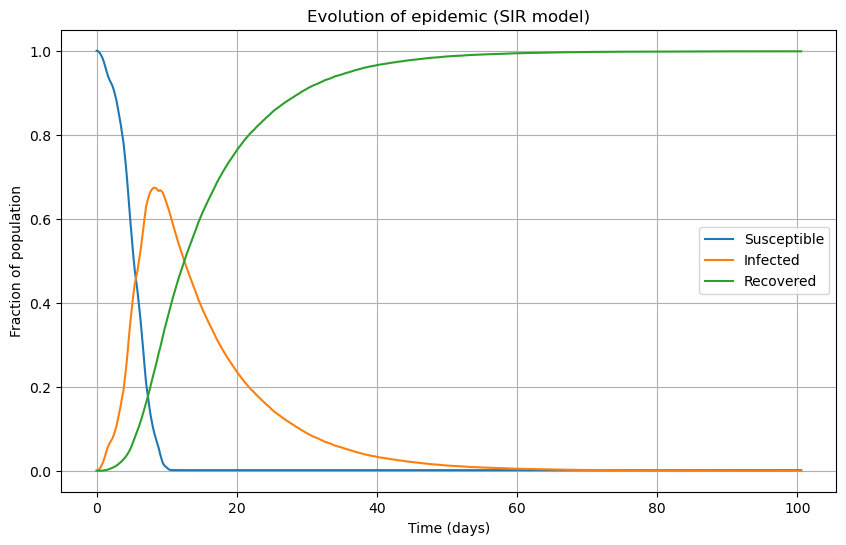

In [ ]:
timesteps = np.linspace(0, sim.max_time, 500)
S, I, R = [], [], []

for t in timesteps:
    s = np.sum(sim.get_node_status(i, t) == 0 for i in range(sim.n_nodes)) / sim.n_nodes
    i = np.sum(sim.get_node_status(i, t) == 1 for i in range(sim.n_nodes)) / sim.n_nodes
    r = np.sum(sim.get_node_status(i, t) == 2 for i in range(sim.n_nodes)) / sim.n_nodes
    S.append(s)
    I.append(i)
    R.append(r)

# Plotting the evolution
plt.figure(figsize=(10, 6))
plt.plot(timesteps, S, label='Susceptible')
plt.plot(timesteps, I, label='Infected')
plt.plot(timesteps, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Fraction of population')
plt.title('Evolution of epidemic (SIR model)')
plt.legend()
plt.grid(True)
plt.show()


Interpretation:
Infection spreads very rapidly during the first 10–15 days.
The number of infected people peaks around day 10.
Then, people gradually recover and the infection vanishes by around day 40–50.
Eventually, almost the entire population recovers, and the number of susceptible individuals approaches zero.

In [12]:
# Time when 60% of the population is infected simultaneously
threshold_I = next(t for t, val in zip(timesteps, I) if val >= 0.6)
print("Time when 60% are infected:", threshold_I)

# Time when 60% are recovered in total
threshold_R = next(t for t, val in zip(timesteps, R) if val >= 0.6)
print("Time when 60% are recovered:", threshold_R)


Time when 60% are infected: 6.851607300672079
Time when 60% are recovered: 14.912321772050994


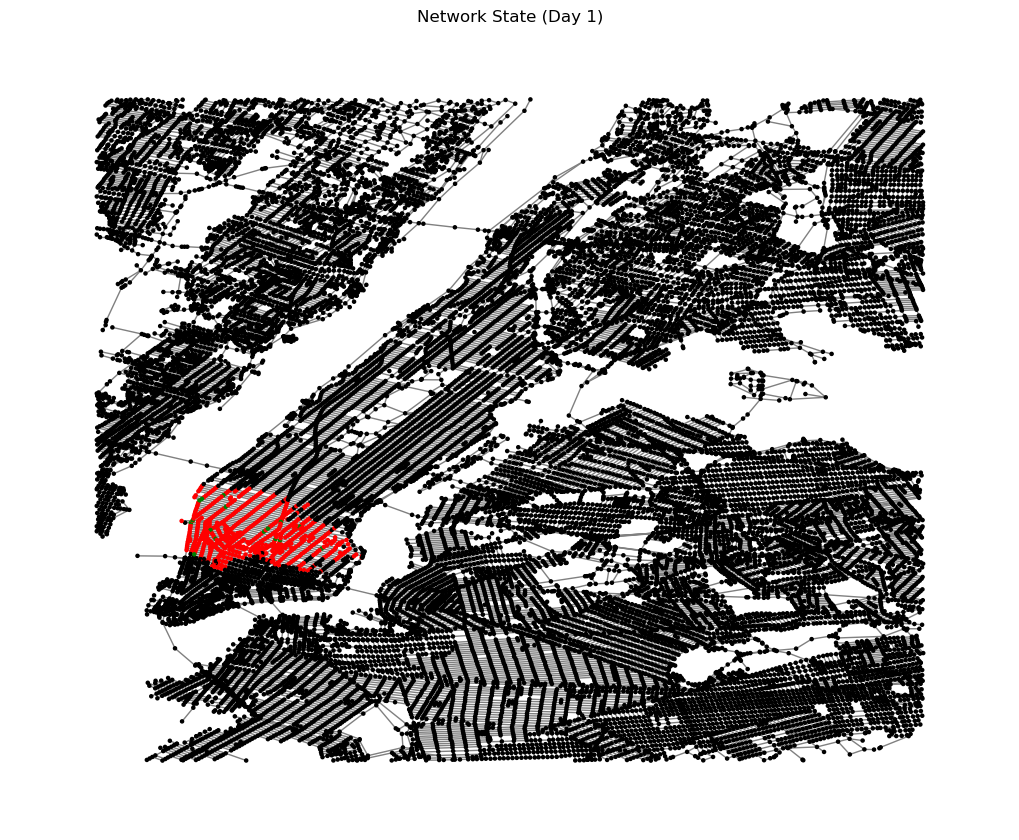

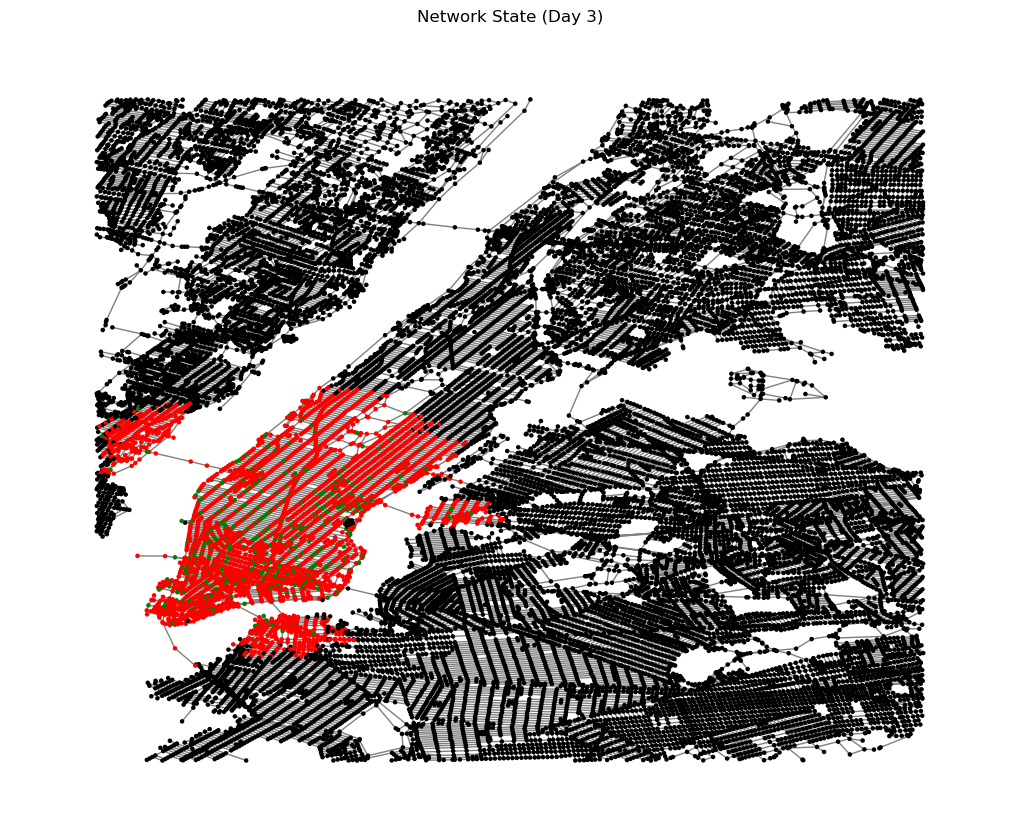

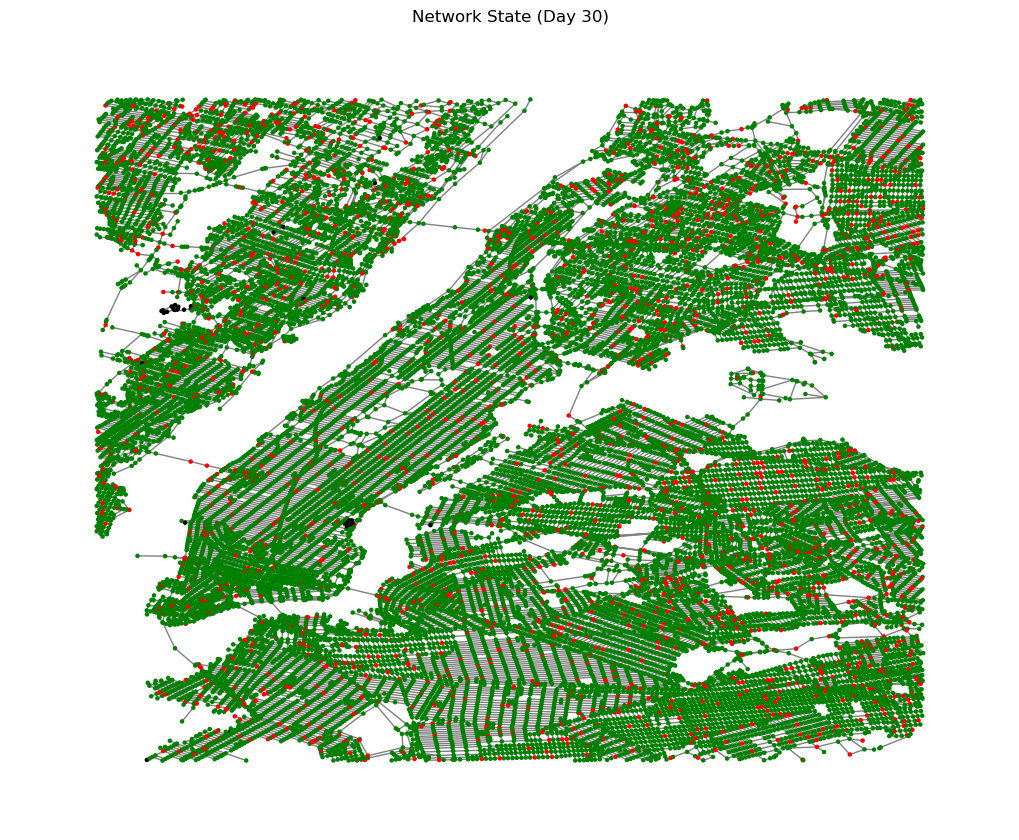

In [13]:
def plot_epidemic_graph(day, sim, G, mapping, title):
    position = {i: tuple(G.nodes[i]['coordinates']) for i in G.nodes}
    status_day = [sim.get_node_status(i, day) for i in range(sim.n_nodes)]
    color_map = ['black' if s == 0 else 'red' if s == 1 else 'green' for s in status_day]

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos=position, node_color=color_map, node_size=5, edge_color='gray', with_labels=False)
    plt.title(f"{title} (Day {day})")
    plt.show()

plot_epidemic_graph(1, sim, G, mapping, "Network State")
plot_epidemic_graph(3, sim, G, mapping, "Network State")
plot_epidemic_graph(30, sim, G, mapping, "Network State")


Observations:
Day 1: Only a few nodes are infected near patient zero.
Day 3: The infection rapidly spreads across neighboring nodes.
Day 30: The epidemic has passed — almost all nodes are recovered (green), and there are very few infected nodes left.

Conclusion :
This simulation demonstrates how a highly infectious disease (high β) with slow recovery (low γ) spreads quickly through a well-connected urban network. Without intervention, nearly the entire population is infected over time.
So, early containment would be critical to reduce peak infection and overall exposure.

---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

In [14]:
import random

def simulate_with_random_removal(G_original, num_edges_to_remove, beta=10.0, gamma=0.1, n_simulations=10, day=30):
    S_list, I_list, R_list = [], [], []
    
    for _ in range(n_simulations):
        # 1. Copy original graph
        G = G_original.copy()
        
        # 2. Randomly remove edges
        edges = list(G.edges())
        edges_to_remove = random.sample(edges, num_edges_to_remove)
        G.remove_edges_from(edges_to_remove)
        
        # 3. Choose random source node
        source = random.choice(list(G.nodes()))
        
        # 4. Simulate epidemic
        sim = SimulationSIR(G, beta=beta, gamma=gamma, verbose=False)
        sim.launch_epidemic(source=source, max_time=100)
        
        # 5. Record population states at day X
        S = sum(sim.get_node_status(i, day) == 0 for i in range(sim.n_nodes)) / sim.n_nodes
        I = sum(sim.get_node_status(i, day) == 1 for i in range(sim.n_nodes)) / sim.n_nodes
        R = sum(sim.get_node_status(i, day) == 2 for i in range(sim.n_nodes)) / sim.n_nodes

        S_list.append(S)
        I_list.append(I)
        R_list.append(R)
    
    # Moyenne sur toutes les simulations
    return np.mean(S_list), np.mean(I_list), np.mean(R_list)


In [ ]:
# 1000 edges
S_1000, I_1000, R_1000 = simulate_with_random_removal(G, num_edges_to_remove=1000)
print(f"With 1000 edges removed at random (Day 30):")
print(f"Average Susceptible: {S_1000:.2%}")
print(f"Average Infected:    {I_1000:.2%}")
print(f"Average Recovered:   {R_1000:.2%}")

# 10000 edges
S_10000, I_10000, R_10000 = simulate_with_random_removal(G, num_edges_to_remove=10000)
print(f"\nWith 10000 edges removed at random (Day 30):")
print(f"Average Susceptible: {S_10000:.2%}")
print(f"Average Infected:    {I_10000:.2%}")
print(f"Average Recovered:   {R_10000:.2%}")


With 1000 edges removed at random (Day 30):
Average Susceptible: 0.47%
Average Infected:    9.46%
Average Recovered:   90.07%

With 10000 edges removed at random (Day 30):
Average Susceptible: 40.63%
Average Infected:    14.21%
Average Recovered:   45.16%


Is this strategy effective?
Partially. When removing 1,000 edges, the reduction in infections is still not significant — the epidemic spreads to almost the entire population. By day 30, only 0.47% of people remain susceptible, while 90.07% have already recovered, meaning the virus has reached nearly everyone.
When removing 10,000 edges, we observe a stronger effect: a larger portion of the population remains uninfected by day 30. In fact, 40.63% of the population is still susceptible, which shows that the spread has been slowed noticeably.
However, this approach remains suboptimal. Since edges are removed at random, we are not specifically targeting the network's most critical connections for disease transmission. As a result, many of the removed edges may have little to no impact on slowing the epidemic.

On average, how many people are in a healthy, infected, and recovered state on day 30?

With 1,000 edges removed:
                Susceptible: 0.47%
                Infected: 9.46%
                Recovered: 90.07%
With 10,000 edges removed:
                Susceptible: 40.63% (higher, meaning the spread was slowed)
                Infected: 14.21% (slightly more active infections at day 30)
                Recovered: 45.16% (fewer people got infected and recovered overall)
                
→ Removing more edges helps, but a smarter, more targeted strategy is clearly more effective

#### Exercise 2.11: Strategy 2

In [ ]:
def simulate_with_smart_removal(G_original, num_edges_to_remove, beta=10.0, gamma=0.1, n_simulations=10, day=30):
    import networkx as nx
    import numpy as np
    import random

    S_list, I_list, R_list = [], [], []

    # Step 1: Compute Approximate edge betweenness centrality
    centrality = nx.edge_betweenness_centrality(G_original, k=500, seed=42)
    
    # Step 2: Sort edges by centrality and select top-k
    edges_sorted = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    edges_to_remove = [edge for edge, _ in edges_sorted[:num_edges_to_remove]]
    
    # Step 3: Run multiple epidemic simulations with random patient zero
    for _ in range(n_simulations):
        G = G_original.copy()
        G.remove_edges_from(edges_to_remove)

        source = random.choice(list(G.nodes()))
        sim = SimulationSIR(G, beta=beta, gamma=gamma, verbose=False)
        sim.launch_epidemic(source=source, max_time=100)

        S = sum(sim.get_node_status(i, day) == 0 for i in range(sim.n_nodes)) / sim.n_nodes
        I = sum(sim.get_node_status(i, day) == 1 for i in range(sim.n_nodes)) / sim.n_nodes
        R = sum(sim.get_node_status(i, day) == 2 for i in range(sim.n_nodes)) / sim.n_nodes

        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return np.mean(S_list), np.mean(I_list), np.mean(R_list)

# Run simulation
S_smart, I_smart, R_smart = simulate_with_smart_removal(G, num_edges_to_remove=2500)

print("With 2500 edges removed using smart (betweenness) strategy (Day 30):")
print(f"Average Susceptible: {S_smart:.2%}")
print(f"Average Infected:    {I_smart:.2%}")
print(f"Average Recovered:   {R_smart:.2%}")


With 2500 edges removed using smart (betweenness) strategy (Day 30):
Average Susceptible: 64.37%
Average Infected:    3.01%
Average Recovered:   32.61%


Our strategy is based on concepts seen in the course, particularly how the structure of the network influences the speed and scale of epidemic spreading.
We focus on removing edges that act as critical connections between different regions of the graph. These are typically the links that allow the epidemic to pass quickly from one cluster of nodes to another. According to what we learned in class, the mixing time of a random walk, and the conductance of the network, strongly affect how fast a disease can propagate. If we reduce the connectivity between different parts of the graph, we increase the time it takes for the infection to spread across the whole network — and in some cases, we prevent it altogether.
By identifying and removing 2,500 such key edges, we aim to fragment the network and isolate groups of nodes from each other, making it more difficult for the epidemic to reach everyone.
We simulated the epidemic 10 times with the same infection and recovery rates, each time starting from a randomly chosen node.


The results on day 30 are:
Average Susceptible: 64.37%
Average Infected: 3.01%
Average Recovered: 32.61%

Compared to the random edge removal strategy:
A significantly higher percentage of the population remains healthy.
The number of infections is drastically reduced.
The infection often stays confined within a local region and does not spread globally.
This result is better than the random removal strategy even when removing 10,000 edges, and it is close to the reference implementation which preserves 70% of healthy individuals.


Conclusion:
This confirms that a graph-aware intervention, based on the principles of network structure, connectivity, and mixing time, is much more effective than removing edges at random